In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Data Preprocessing
missing_values = ['Nan', 'n/a', '--']
data = pd.read_csv('/Users/paskou/Documents/Imperial/Big Data I/Assignment_1/Loan_data_part_I.csv', na_values = missing_values)
#data.isnull().values.any()
data['loan_status'][data['loan_status'] == 'Fail'] = 0
data['loan_status'][data['loan_status'] == 'Current'] = 1
data = data.drop('id', axis = 1)
data = data.astype('int')
data.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,loan_status,loan_amnt,term,int_rate,grade,sub_grade,installment,pymnt_plan,annual_inc,emp_length,...,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit
count,61072.000000,61072.000000,61072.000000,61072.000000,61072.000000,61072.000000,61072.000000,61072.000000,6.107200e+04,61072.000000,...,61072.000000,61072.000000,61072.000000,61072.000000,6.107200e+04,6.107200e+04,61072.000000,61072.000000,61072.000000,61072.000000
mean,0.841728,14980.569655,43.019780,13.289740,1.728599,10.731661,447.561436,0.001654,8.256371e+04,5.639327,...,0.129748,16079.454447,48.175874,0.041427,1.462970e+05,1.835678e+05,23.410286,53965.677839,37677.943673,23761.373903
std,0.364999,9677.822935,10.917846,5.592948,1.261586,6.510608,286.975674,0.040633,4.506844e+05,3.834504,...,0.352161,21656.437108,24.711604,0.331746,1.630864e+05,1.831050e+05,11.879881,51343.560110,44996.832289,23316.613872
min,0.000000,1000.000000,36.000000,5.000000,0.000000,0.000000,30.000000,0.000000,6.000000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,3.000000e+02,2.000000,0.000000,0.000000,200.000000
25%,1.000000,7500.000000,36.000000,9.000000,1.000000,6.000000,240.000000,0.000000,4.817750e+04,2.000000,...,0.000000,5619.000000,29.000000,0.000000,3.050475e+04,5.379975e+04,15.000000,22271.750000,10196.500000,8600.000000
50%,1.000000,12000.000000,36.000000,12.000000,2.000000,10.000000,371.000000,0.000000,6.750000e+04,5.000000,...,0.000000,10872.000000,47.000000,0.000000,8.108300e+04,1.161350e+05,22.000000,39889.000000,24912.500000,16800.500000
75%,1.000000,20000.000000,60.000000,16.000000,2.000000,14.000000,597.000000,0.000000,9.600000e+04,10.000000,...,0.000000,19510.250000,67.000000,0.000000,2.191132e+05,2.649670e+05,30.000000,68198.250000,48625.250000,30900.000000
max,1.000000,40000.000000,60.000000,30.000000,6.000000,34.000000,1719.000000,1.000000,1.100000e+08,10.000000,...,6.000000,863811.000000,145.000000,29.000000,3.188187e+06,3.431897e+06,151.000000,912795.000000,694521.000000,513700.000000


In [3]:
# Splitting the dataset into
X = data.drop('loan_status', axis = 1)
y = data['loan_status']

# Applying Random Undersampling with replacement
#rus = RandomUnderSampler(random_state = 69, replacement = True)
#X, y = rus.fit_sample(X, y)

# Applying Random Oversampling with replacement
ros = RandomOverSampler(random_state = 69)
X, y = ros.fit_sample(X, y)

# Applying Random Oversampling with replacement
#ross = SMOTE(random_state = 69)
#X, y = ross.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 69)

In [4]:
# Standardising the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [5]:
# Normalising the data (min max)
#scaler = MinMaxScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## Random Forest

In [39]:
clf = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', 
                              min_samples_split = 20, min_samples_leaf = 10, random_state = 69)

In [ ]:
# Grid Search for hyperparameters optimization
criterion = ['gini', 'entropy']
n_estimators = [500, 1000]
min_samples_split = [20, 25, 30, 35, 40]
min_samples_leaf = [1, 3, 5, 7, 10]

param_grid = dict(min_samples_split = min_samples_split, n_estimators = n_estimators, 
                  criterion = criterion, min_samples_leaf = min_samples_leaf)

cv = KFold(n_splits = 5, shuffle = True, random_state = 69)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

In [40]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=69, verbose=0,
                       warm_start=False)

### Results Test Set

In [41]:
RF_test_fpr, RF_test_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
RF_test_roc_auc = auc(RF_test_fpr, RF_test_tpr)
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(RF_test_roc_auc, accuracy))

The roc auc in the test set is 0.962 and the accuracy is 0.89


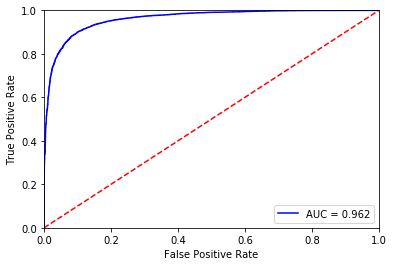

In [42]:
# Plotting the graph
plt.plot(RF_test_fpr, RF_test_tpr, 'b', label = 'AUC = %0.3f' % RF_test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
# Confusion matrix
cf_RF = confusion_matrix(y_test, clf.predict(X_test))
#fig_RF = plt.figure(figsize = (4,3))
#plt.title('Random Forest - Confusion Matirx')
#ax = fig_RF.gca()
#sn.heatmap(cf_RF, annot=True)
cf_RF

array([[9598,  699],
       [1468, 8798]])

## Neural Networks

In [24]:
# Hyperparameters to be optimzed

#lr = [0.1, 0.01, 0.001]
#optimizer = ['adam', 'SGD', 'RMSprop']
kernel_initializer = ['normal', 'uniform']
batch_size = [15, 30, 60]
#epochs = [100, 150, 200]
#activation = ['relu', 'elu', 'tanh']

In [25]:
def build_classifier():#optimizer = optimizer, lr = lr, kernel_initializer = kernel_initializer):
    # Initialising the ANN
    classifier = Sequential()
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 20, kernel_initializer = 'normal', activation = 'relu', input_dim = 46))
    # Adding dropout for NN training
    classifier.add(Dropout(0.5))
    # Adding the second hidden layer
    classifier.add(Dense(units = 7, kernel_initializer = 'normal', activation = 'relu'))
    # Adding dropout for NN training
    classifier.add(Dropout(0.5))
    # Adding the third hidden layer
    classifier.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
    # Adding the output layer
    classifier.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'sigmoid'))
    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [26]:
classifier = KerasClassifier(build_fn = build_classifier)

In [27]:
classifier.fit(X_train, y_train, batch_size = 30, 
               epochs = 70)#, callbacks = [EarlyStopping(monitor = 'loss', patience = 5)])

Epoch 1/70
82249/82249 [==============================] - 6s 79us/step - loss: 0.6429 - accuracy: 0.6348
Epoch 2/70
82249/82249 [==============================] - 6s 68us/step - loss: 0.6331 - accuracy: 0.6477
Epoch 3/70
82249/82249 [==============================] - 6s 69us/step - loss: 0.6316 - accuracy: 0.6480
Epoch 4/70
82249/82249 [==============================] - 6s 69us/step - loss: 0.6303 - accuracy: 0.6500
Epoch 5/70
82249/82249 [==============================] - 5s 65us/step - loss: 0.6299 - accuracy: 0.6507
Epoch 6/70
82249/82249 [==============================] - 5s 64us/step - loss: 0.6288 - accuracy: 0.6506
Epoch 7/70
82249/82249 [==============================] - 5s 66us/step - loss: 0.6283 - accuracy: 0.6524
Epoch 8/70
82249/82249 [==============================] - 6s 67us/step - loss: 0.6268 - accuracy: 0.6531
Epoch 9/70
82249/82249 [==============================] - 5s 66us/step - loss: 0.6267 - accuracy: 0.6546
Epoch 10/70
82249/82249 [==============================

In [ ]:
# Grid Search for hyperparameters optimization

param_grid = dict(kernel_initializer = kernel_initializer, batch_size = batch_size)#optimizer = optimizer, epochs = epochs

cv = KFold(n_splits = 5, shuffle = True, random_state = 69)
grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
grid_search = grid_search.fit(X = X_train, y = y_train)

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

### Results Test Set

In [28]:
NN_test_fpr, NN_test_tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
NN_test_roc_auc = auc(NN_test_fpr, NN_test_tpr)
accuracy = accuracy_score(y_test, classifier.predict(X_test))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(NN_test_roc_auc, accuracy))

The roc auc in the test set is 0.725 and the accuracy is 0.67


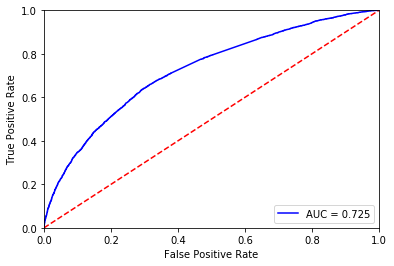

In [29]:
# Plotting the graph
plt.plot(NN_test_fpr, NN_test_tpr, 'b', label = 'AUC = %0.3f' % NN_test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [30]:
# Confusion matrix
cf_NN = confusion_matrix(y_test, classifier.predict(X_test))
#fig_NN = plt.figure(figsize = (7,5))
#plt.title('Neural Networks - Confusion Matirx')
#ax = fig_NN.gca()
#sn.heatmap(cf_NN, annot=True)
cf_NN

array([[7087, 3210],
       [3557, 6709]])

## Out of Sample

In [31]:
# Data Preprocessing
missing_values = ['Nan', 'n/a', '--']
df = pd.read_csv('/Users/paskou/Documents/Imperial/Big Data I/Assignment_1/Loan_data_part_II.csv', na_values = missing_values)
#df.isnull().values.any()
df['loan_status'][df['loan_status'] == 'Fail'] = 0
df['loan_status'][df['loan_status'] == 'Current'] = 1
df = df.drop('id', axis = 1)
df = df.astype('int')
df.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,loan_status,loan_amnt,term,int_rate,grade,sub_grade,installment,pymnt_plan,annual_inc,emp_length,...,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit
count,56858.000000,56858.000000,56858.000000,56858.000000,56858.000000,56858.000000,56858.000000,56858.000000,5.685800e+04,56858.000000,...,56858.000000,56858.000000,56858.000000,56858.000000,5.685800e+04,5.685800e+04,56858.000000,56858.000000,56858.000000,56858.000000
mean,0.886436,15730.996518,43.542158,12.583629,1.581044,9.883112,459.807292,0.001126,8.172863e+04,5.673555,...,0.131978,16157.137606,44.436983,0.041349,1.465933e+05,1.871312e+05,22.773312,52951.649355,36597.190439,26034.567044
std,0.317283,10024.372216,11.141357,5.278695,1.204951,6.064186,289.315062,0.033532,8.077752e+04,3.823672,...,0.344649,23235.287381,25.200620,0.342451,1.683264e+05,1.892716e+05,12.000394,52809.057967,45070.569049,25512.570272
min,0.000000,1000.000000,36.000000,5.000000,0.000000,0.000000,6.000000,0.000000,2.500000e+01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+02,2.000000,0.000000,0.000000,100.000000
25%,1.000000,8000.000000,36.000000,9.000000,1.000000,5.000000,248.000000,0.000000,4.800000e+04,2.000000,...,0.000000,5241.000000,25.000000,0.000000,2.846925e+04,5.329250e+04,14.000000,20726.250000,9149.250000,9500.000000
50%,1.000000,13400.000000,36.000000,11.000000,1.000000,9.000000,381.000000,0.000000,6.800000e+04,5.000000,...,0.000000,10551.500000,43.000000,0.000000,7.808500e+04,1.193000e+05,21.000000,38662.000000,23866.000000,18500.000000
75%,1.000000,21000.000000,60.000000,16.000000,2.000000,14.000000,620.000000,0.000000,9.763750e+04,10.000000,...,0.000000,19318.750000,63.000000,0.000000,2.199355e+05,2.706010e+05,29.000000,67183.750000,47537.250000,33800.000000
max,1.000000,40000.000000,60.000000,30.000000,6.000000,34.000000,1714.000000,1.000000,7.845315e+06,10.000000,...,4.000000,629372.000000,154.000000,22.000000,3.250980e+06,3.817941e+06,151.000000,720502.000000,676089.000000,372000.000000


In [32]:
# Splitting the dataset into
X = df.drop('loan_status', axis = 1)
y = df['loan_status']

In [33]:
# Standardising the data
sc_x_oos = StandardScaler()
X = sc_x_oos.fit_transform(X)

In [34]:
# Normalising the data (min max)
#scaler_oos = MinMaxScaler()
#scaler_oos.fit(X)
#X = scaler.transform(X)

## Random Forest Out of Sample

In [35]:
RF_oos_fpr, RF_oos_tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
RF_oos_roc_auc = auc(RF_oos_fpr, RF_oos_tpr)
accuracy = accuracy_score(y, clf.predict(X))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(RF_oos_roc_auc, accuracy))

The roc auc in the test set is 0.713 and the accuracy is 0.72


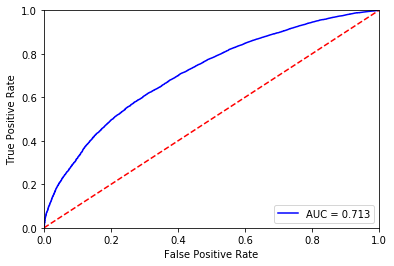

In [36]:
# Plotting the graph
plt.plot(RF_oos_fpr, RF_oos_tpr, 'b', label = 'AUC = %0.3f' % RF_oos_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network Out of Sample

In [37]:
NN_oos_fpr, NN_oos_tpr, _ = roc_curve(y, classifier.predict_proba(X)[:,1])
NN_oos_roc_auc = auc(NN_oos_fpr, NN_oos_tpr)
accuracy = accuracy_score(y, classifier.predict(X))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(NN_oos_roc_auc, accuracy))

The roc auc in the test set is 0.712 and the accuracy is 0.57


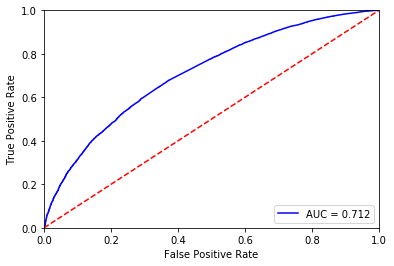

In [38]:
# Plotting the graph
plt.plot(NN_oos_fpr, NN_oos_tpr, 'b', label = 'AUC = %0.3f' % NN_oos_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()